In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchmetrics.classification import Accuracy, Precision, Recall
from transformers import (
    AutoProcessor,
    Idefics3ForConditionalGeneration,
    Idefics3VisionTransformer,
)

from pyroml import PyroModule, Trainer
from pyroml.core.stage import Stage
from pyroml.models.backbone import num_params
from pyroml.template.flowers102.dataset import Flowers102Dataset
from pyroml.callbacks.progress.tqdm_progress import TQDMProgress

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### 1. Instantiate vision model feature extractor

In [2]:
model_id = "HuggingFaceTB/SmolVLM-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [7]:
feature_extractor = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    # torch_dtype=torch.bfloat16,
    _attn_implementation="eager",  # flash_attention_2
    device_map="cpu",
)
# Only extract the vision part
feature_extractor = feature_extractor.model.vision_model
f"{num_params(feature_extractor):,}"

'412,987,248'

### 2. Create Flowers102 dataset with feature extractor preprocessor

In [3]:
class Flowers102ProcessorDataset(Flowers102Dataset):
    def __init__(self, split: str, processor: AutoProcessor):
        super().__init__(split=split)
        self.processor = processor

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        item["image"] = processor.image_processor(
            item["image"], return_tensors="pt"
        ).pixel_values[0, -1]
        return item

In [4]:
tr_dataset = Flowers102ProcessorDataset(split="train", processor=processor)
te_dataset = Flowers102ProcessorDataset(split="test", processor=processor)

(
    len(tr_dataset),
    len(te_dataset),
    tr_dataset[0].keys(),
    tr_dataset[0]["image"].shape,
)

(7169, 1020, dict_keys(['image', 'label']), torch.Size([3, 384, 384]))

### 3. Obtain features from feature extractor

In [7]:
def get_features(dataset: Flowers102ProcessorDataset, model: Idefics3VisionTransformer):
    model.eval().to(DEVICE)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
    all_features = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x = batch["image"].to(DEVICE)
            features: torch.Tensor = model(x).last_hidden_state.mean(dim=1)
            all_features.append(features.detach().cpu())
    model.cpu()
    return torch.cat(all_features)

In [15]:
tr_feats = get_features(tr_dataset, feature_extractor)
te_feats = get_features(te_dataset, feature_extractor)
tr_feats.shape, te_feats.shape

100%|██████████| 64/64 [02:57<00:00,  2.77s/it]


(torch.Size([7169, 1152]), torch.Size([1020, 1152]))

In [ ]:
# >> You might want to save the features in case something goes wrong later
# torch.save(tr_feats, "teacher_smolvlm-instruct_tr_feats.pt")
# torch.save(te_feats, "teacher_smolvlm-instruct_te_feats.pt")

# >> And in the event that something does go wrong, no need to precompute features again, just load them
# tr_feats = torch.load("teacher_smolvlm-instruct_tr_feats.pt")
# te_feats = torch.load("teacher_smolvlm-instruct_te_feats.pt")
# tr_feats.shape, te_feats.shape

### 4. Create features datasets, using precomputed features from above

In [9]:
class FeatsDataset(torch.utils.data.Dataset):
    """
    Uses the precomputed features from SmolVLM vision model and the dataset labels
    """

    def __init__(self, feats: torch.Tensor, dataset: Flowers102ProcessorDataset):
        assert len(feats) == len(dataset)
        self.feats = feats
        # Use internal Flowers102 Dataset since we don't need the Processor here
        self.dataset = dataset.ds

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        feat = self.feats[idx]
        label = self.dataset[idx]["label"]
        return dict(feat=feat, label=label)

In [10]:
tr_feats_dataset = FeatsDataset(feats=tr_feats, dataset=tr_dataset)
te_feats_dataset = FeatsDataset(feats=te_feats, dataset=te_dataset)

### 5. Create classifier taking precomputed features as input

In [11]:
class FeaturesClassifier(PyroModule):
    def __init__(self, last_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(last_dim, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        metrics_kwargs = dict(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.pre = Precision(**metrics_kwargs)
        self.acc = Accuracy(**metrics_kwargs)
        self.rec = Recall(**metrics_kwargs)
        self.pre_5 = Precision(**metrics_kwargs, top_k=5)
        self.acc_5 = Accuracy(**metrics_kwargs, top_k=5)
        self.rec_5 = Recall(**metrics_kwargs, top_k=5)

    def configure_optimizers(self, loop):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.trainer.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=1, gamma=0.9999
        )

    def forward(self, x: torch.Tensor):
        x = self.fc(x)
        return x

    def step(self, batch: dict[str, torch.Tensor], stage: Stage):
        x, y = batch["feat"], batch["label"]
        preds = self(x)
        loss: torch.Tensor = self.loss_fn(preds, y)

        preds = torch.softmax(preds, dim=-1)
        self.log(
            lr=self.scheduler.get_last_lr()[0],
            loss=loss.item(),
            acc=self.acc(preds, y),
            pre=self.pre(preds, y),
            rec=self.rec(preds, y),
            acc_5=self.acc_5(preds, y),
            pre_5=self.pre_5(preds, y),
            rec_5=self.rec_5(preds, y),
        )

        if stage == Stage.TRAIN:
            return loss

        preds = torch.softmax(preds, dim=-1)
        return preds

In [12]:
last_dim = tr_feats.shape[1]
classifier = FeaturesClassifier(last_dim=last_dim, num_classes=102)
f"{num_params(classifier):,}"

'117,606'

### 6. Train and evaluate the classifier

In [13]:
trainer = Trainer(
    lr=0.005,
    batch_size=176,
    max_epochs=12,
    evaluate_on=False,
    dtype=torch.bfloat16,
    num_workers=0,
    device=DEVICE,
    callbacks=[TQDMProgress()],
)
tr_tracker = trainer.fit(classifier, tr_feats_dataset)

Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

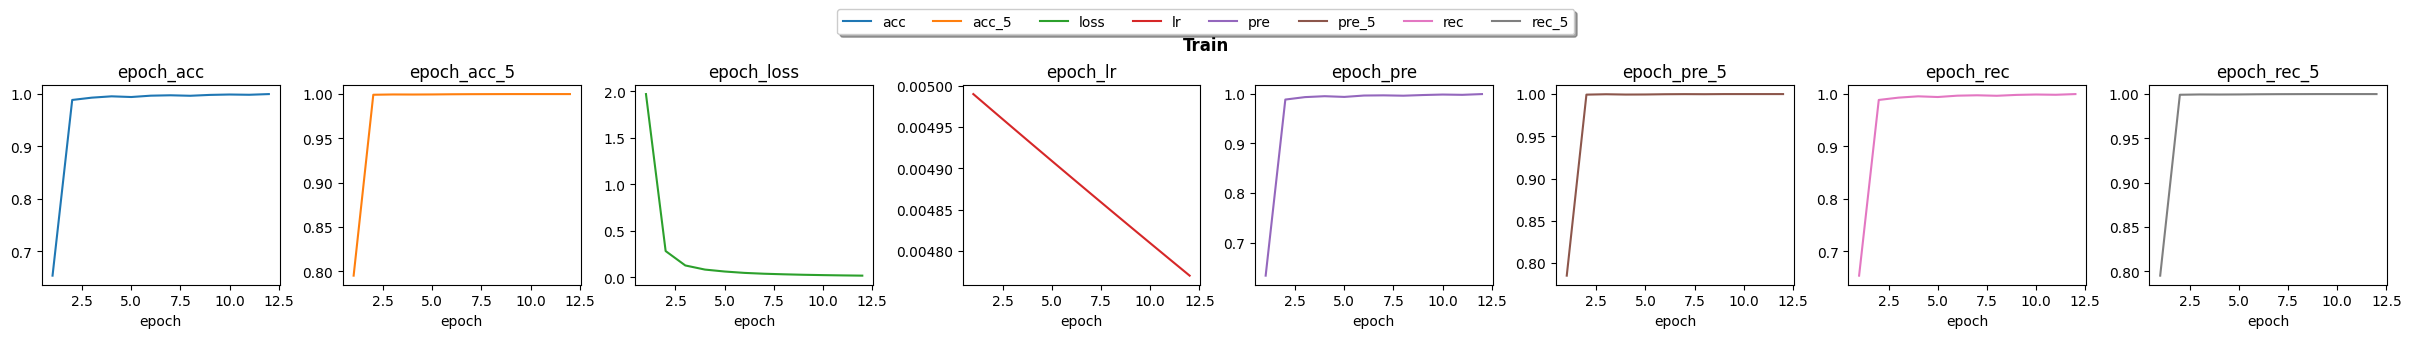

In [14]:
tr_tracker.plot(epoch=True)

In [15]:
te_tracker = trainer.evaluate(classifier, te_feats_dataset)

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
import rich

rich.print(te_tracker.get_last_epoch_metrics())

{
    'lr': 0.004759941852322568,
    'loss': 0.05358679903050264,
    'acc': 0.9850654800732931,
    'pre': 0.9863804777463278,
    'rec': 0.9850654800732931,
    'acc_5': 0.9982456167538961,
    'pre_5': 0.9992690086364746,
    'rec_5': 0.9982456167538961
}

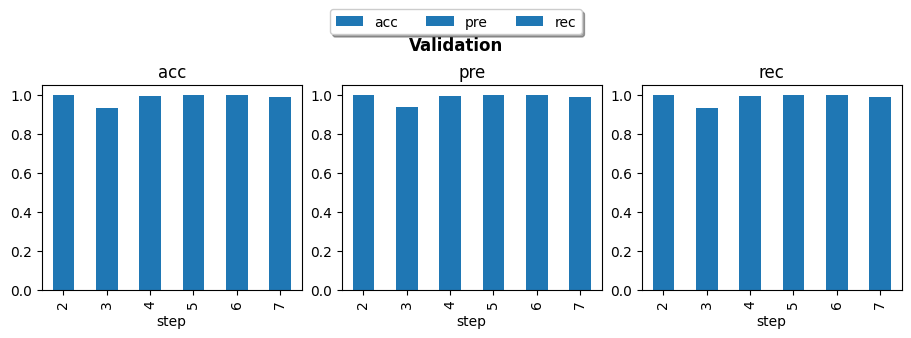

In [17]:
te_tracker.plot(kind="bar", plot_keys=["acc", "pre", "rec"])